
# FASTSim Demonstration

![fastsim icon](icon_fastsim.jpg)

Developed by NREL, the Future Automotive Systems Technology Simulator (FASTSim) evaluates the impact of technology improvements on efficiency, performance, cost, and battery life in conventional vehicles, hybrid electric vehicles (HEVs), plug-in hybrid electric vehicles (PHEVs), and all-electric vehicles (EVs).

FASTSim answers questions such as:
- Which battery sizes are most cost effective for a PHEV or EV?
- At what battery prices do PHEVs and EVs become cost effective?
- On average, how much fuel does a PHEV with a 30-mile electric range save?
- How much fuel savings does an HEV provide for a given drive cycle?
- How do lifetime costs and petroleum use compare for conventional vehicles, HEVs, PHEVs, and EVs?

FASTSim was originally implemented in Microsoft Excel. The pythonic implementation of FASTSim, demonstrated here, captures the drive cycle energy consumption simulation component of the software. The python version of FASTSim is more convenient than the Excel version when very high computational speed is desired, such as for simulating a large batch of drive cycles.

In [1]:
import sys
import os
from pathlib import Path
# allow it to find simdrive module
fsimpath=str(Path(os.getcwd()).parents[0])
if fsimpath not in sys.path:
    sys.path.append(fsimpath)
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import importlib
# import seaborn as sns
# sns.set(font_scale=2, style='whitegrid')

%matplotlib inline

In [2]:
# local modules
from fastsim import simdrive, vehicle, cycle
# importlib.reload(simdrive)
# importlib.reload(cycle)

## Individual Drive Cycle
### Load Drive Cycle

Default (UDDS, US06, HWFET) cycles can be loaded from the ```../cycles``` directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys: 

```['cycGrade', 'cycMps', 'cycSecs', 'cycRoadType']```
- cycGrade = Road grade [%/100]
- cycMps = Vehicle speed [meters per second]
- cycSecs = Relative time in the cycles [seconds]
- cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle

There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.

In [11]:
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

0.002991914749145508


### Load Powertrain Model

A vehicle database in CSV format is required to be in the working directory where FASTSim is running (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle attributes from the database and contructs the powertrain model (engine efficiency map, etc.). An integer value corresponds to each vehicle in the database. To add a new vehicle, simply populate a new row to the vehicle database CSV.

In [12]:
t0 = time.time()
veh = vehicle.Vehicle(9)
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

0.030912399291992188


### Run FASTSim

The "sim_drive" function takes the drive cycle and vehicle models defined above as inputs. The output is a dictionary of time series and scalar values described the simulation results. Typically of interest is the "gge" key, which is an array of time series energy consumption data at each time step in the drive cycle.

If running FASTSim in batch over many drive cycles, the output from "sim_drive" can be written to files or database for batch post-processing. 

In [13]:
t0 = time.time()

# instantiate and run classic version via convenience wrapper
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit)
# sim_drive.sim_drive()

# instantiate and run JIT compiled version directly
# SimDriveJit can only take one mandatory positional argument for initSoc
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive() 

print(time.time() - t0)

0.011940479278564453


In [14]:
t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(time.time() - t0)

0.0728607177734375


### Results

In [7]:
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch']]
df['speed'] = cyc.cycMps * 2.23694  # Convert mps to mph

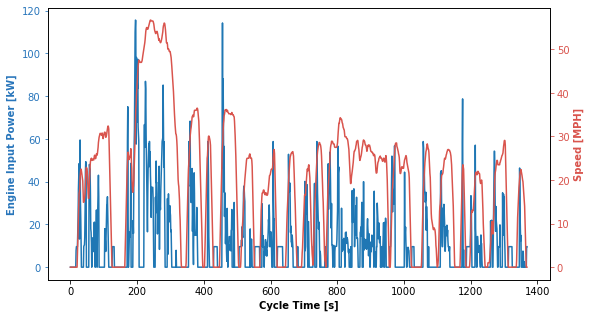

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.fcKwInAch.plot(ax=ax, label='kW')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Engine Input Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax2.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:pale red')
ax2.grid(False)
ax2.tick_params('y', colors='xkcd:pale red')

## Running sim_drive_step() with modified auxInKw
Note that auxInKw is the only variable setup to be externally modified as of 1 July 2020

In [9]:
veh_jit = vehicle.Vehicle(9).get_numba_veh()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
initSoc = 0.7935
sim_drive.essCurKwh[0] = initSoc * sim_drive.veh.maxEssKwh
sim_drive.soc[0] = initSoc

while sim_drive.i < len(cyc.cycSecs):
    sim_drive.auxInKw[sim_drive.i] = 10 # large value to exaggerate results
    sim_drive.sim_drive_step('auxInKw')

plt.plot(cyc.cycSecs, sim_drive.fcKwOutAch, label='eng out')
plt.plot(cyc.cycSecs, sim_drive.essKwOutAch, label='mot in')
plt.xlabel('Time [s]')
plt.ylabel('Power [kW]')
plt.legend()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m- Resolution failure for literal arguments:
[1mtoo many positional arguments[0m
[0m[1m- Resolution failure for non-literal arguments:
[1mNone[0m
[0m[0m
[0m[1mDuring: resolving callee type: BoundFunction((<class 'numba.core.types.misc.ClassInstanceType'>, 'sim_drive_step') for instance.jitclass.SimDriveJit#1e731d249c8<curMaxFsKwOut:array(float64, 1d, A),fcTransLimKw:array(float64, 1d, A),fcFsLimKw:array(float64, 1d, A),fcMaxKwIn:array(float64, 1d, A),curMaxFcKwOut:array(float64, 1d, A),essCapLimDischgKw:array(float64, 1d, A),curMaxEssKwOut:array(float64, 1d, A),curMaxAvailElecKw:array(float64, 1d, A),essCapLimChgKw:array(float64, 1d, A),curMaxEssChgKw:array(float64, 1d, A),curMaxElecKw:array(float64, 1d, A),mcElecInLimKw:array(float64, 1d, A),mcTransiLimKw:array(float64, 1d, A),curMaxMcKwOut:array(float64, 1d, A),essLimMcRegenPercKw:array(float64, 1d, A),essLimMcRegenKw:array(float64, 1d, A),curMaxMechMcKwIn:array(float64, 1d, A),curMaxTransKwOut:array(float64, 1d, A),cycDragKw:array(float64, 1d, A),cycAccelKw:array(float64, 1d, A),cycAscentKw:array(float64, 1d, A),cycTracKwReq:array(float64, 1d, A),curMaxTracKw:array(float64, 1d, A),spareTracKw:array(float64, 1d, A),cycRrKw:array(float64, 1d, A),cycWheelRadPerSec:array(float64, 1d, A),cycTireInertiaKw:array(float64, 1d, A),cycWheelKwReq:array(float64, 1d, A),regenContrLimKwPerc:array(float64, 1d, A),cycRegenBrakeKw:array(float64, 1d, A),cycFricBrakeKw:array(float64, 1d, A),cycTransKwOutReq:array(float64, 1d, A),cycMet:array(float64, 1d, A),transKwOutAch:array(float64, 1d, A),transKwInAch:array(float64, 1d, A),curSocTarget:array(float64, 1d, A),minMcKw2HelpFc:array(float64, 1d, A),mcMechKwOutAch:array(float64, 1d, A),mcElecKwInAch:array(float64, 1d, A),auxInKw:array(float64, 1d, A),roadwayChgKwOutAch:array(float64, 1d, A),minEssKw2HelpFc:array(float64, 1d, A),essKwOutAch:array(float64, 1d, A),fcKwOutAch:array(float64, 1d, A),fcKwOutAch_pct:array(float64, 1d, A),fcKwInAch:array(float64, 1d, A),fsKwOutAch:array(float64, 1d, A),fsKwhOutAch:array(float64, 1d, A),essCurKwh:array(float64, 1d, A),soc:array(float64, 1d, A),regenBufferSoc:array(float64, 1d, A),essRegenBufferDischgKw:array(float64, 1d, A),maxEssRegenBufferChgKw:array(float64, 1d, A),essAccelBufferChgKw:array(float64, 1d, A),accelBufferSoc:array(float64, 1d, A),maxEssAccelBufferDischgKw:array(float64, 1d, A),essAccelRegenDischgKw:array(float64, 1d, A),mcElectInKwForMaxFcEff:array(float64, 1d, A),electKwReq4AE:array(float64, 1d, A),desiredEssKwOutForAE:array(float64, 1d, A),essAEKwOut:array(float64, 1d, A),erAEKwOut:array(float64, 1d, A),essDesiredKw4FcEff:array(float64, 1d, A),essKwIfFcIsReq:array(float64, 1d, A),curMaxMcElecKwIn:array(float64, 1d, A),fcKwGapFrEff:array(float64, 1d, A),erKwIfFcIsReq:array(float64, 1d, A),mcElecKwInIfFcIsReq:array(float64, 1d, A),mcKwIfFcIsReq:array(float64, 1d, A),mcMechKw4ForcedFc:array(float64, 1d, A),fcTimeOn:array(float64, 1d, A),prevfcTimeOn:array(float64, 1d, A),mpsAch:array(float64, 1d, A),mphAch:array(float64, 1d, A),distMeters:array(float64, 1d, A),distMiles:array(float64, 1d, A),highAccFcOnTag:array(float64, 1d, A),reachedBuff:array(float64, 1d, A),maxTracMps:array(float64, 1d, A),addKwh:array(float64, 1d, A),dodCycs:array(float64, 1d, A),essPercDeadArray:array(float64, 1d, A),dragKw:array(float64, 1d, A),essLossKw:array(float64, 1d, A),accelKw:array(float64, 1d, A),ascentKw:array(float64, 1d, A),rrKw:array(float64, 1d, A),motor_index_debug:array(float64, 1d, A),debug_flag:array(float64, 1d, A),curMaxRoadwayChgKw:array(float64, 1d, A),i:int32,fcForcedOn:array(bool, 1d, A),fcForcedState:array(int32, 1d, A),canPowerAllElectrically:array(bool, 1d, A),mpgge:float64,roadwayChgKj:float64,essDischgKj:float64,battery_kWh_per_mi:float64,electric_kWh_per_mi:float64,fuelKj:float64,ess2fuelKwh:float64,Gallons_gas_equivalent_per_mile:float64,mpgge_elec:float64,grid_mpgge_elec:float64,veh:instance.jitclass.TypedVehicle#1e732e00a48<Selection:int32,Scenario_name:unicode_type,vehPtType:int32,dragCoef:float64,frontalAreaM2:float64,gliderKg:float64,vehCgM:float64,driveAxleWeightFrac:float64,wheelBaseM:float64,cargoKg:float64,vehOverrideKg:float64,maxFuelStorKw:float64,fuelStorSecsToPeakPwr:float64,fuelStorKwh:float64,fuelStorKwhPerKg:float64,maxFuelConvKw:float64,fcEffType:int32,fcAbsEffImpr:float64,fuelConvSecsToPeakPwr:float64,fuelConvBaseKg:float64,fuelConvKwPerKg:float64,maxMotorKw:float64,motorPeakEff:float64,motorSecsToPeakPwr:float64,stopStart:bool,mcPeKgPerKw:float64,mcPeBaseKg:float64,maxEssKw:float64,maxEssKwh:float64,essKgPerKwh:float64,essBaseKg:float64,essRoundTripEff:float64,essLifeCoefA:float64,essLifeCoefB:float64,wheelInertiaKgM2:float64,numWheels:float64,wheelRrCoef:float64,wheelRadiusM:float64,wheelCoefOfFric:float64,minSoc:float64,maxSoc:float64,essDischgToFcMaxEffPerc:float64,essChgToFcMaxEffPerc:float64,maxAccelBufferMph:float64,maxAccelBufferPercOfUseableSoc:float64,percHighAccBuf:float64,mphFcOn:float64,kwDemandFcOn:float64,altEff:float64,chgEff:float64,auxKw:float64,forceAuxOnFC:bool,transKg:float64,transEff:float64,compMassMultiplier:float64,essToFuelOkError:float64,maxRegen:float64,valUddsMpgge:float64,valHwyMpgge:float64,valCombMpgge:float64,valUddsKwhPerMile:float64,valHwyKwhPerMile:float64,valCombKwhPerMile:float64,valCdRangeMi:float64,valConst65MphKwhPerMile:float64,valConst60MphKwhPerMile:float64,valConst55MphKwhPerMile:float64,valConst45MphKwhPerMile:float64,valUnadjUddsKwhPerMile:float64,valUnadjHwyKwhPerMile:float64,val0To60Mph:float64,valEssLifeMiles:float64,valRangeMiles:float64,valVehBaseCost:float64,valMsrp:float64,minFcTimeOn:float64,idleFcKw:float64,MaxRoadwayChgKw:array(float64, 1d, A),chargingOn:bool,noElecSys:bool,noElecAux:bool,vehTypeSelection:int32,fcEffArray:array(float64, 1d, A),fcKwOutArray:array(float64, 1d, A),maxFcEffKw:float64,fcMaxOutkW:float64,mcKwInArray:array(float64, 1d, A),mcKwOutArray:array(float64, 1d, A),mcMaxElecInKw:float64,mcFullEffArray:array(float64, 1d, A),mcEffArray:array(float64, 1d, A),regenA:float64,regenB:float64,vehKg:float64,maxTracMps2:float64,maxRegenKwh:float64>,cyc:instance.jitclass.TypedCycle#1e732df10c8<cycSecs:array(float64, 1d, A),cycMps:array(float64, 1d, A),cycGrade:array(float64, 1d, A),cycRoadType:array(float64, 1d, A),cycMph:array(float64, 1d, A),secs:array(float64, 1d, A)>,dragKj:float64,ascentKj:float64,rrKj:float64,brakeKj:float64,transKj:float64,mcKj:float64,essEffKj:float64,auxKj:float64,fcKj:float64,netKj:float64,keKj:float64,energyAuditError:float64>)[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m


## Batch Drive Cycles - TSDC Drive Cycles

FASTSim's most significant advantage over other powertrain simulation tools comes from the ability to simulate many drive cycles quickly. The same three steps described above (load cycle, load model, run FASTSim) will be used here, however, the demonstration highlights how quickly FASTSim runs over __2,225 miles of driving__ data for 22 vehicles.  Running on a single core, the 241 drive cycles take roughly 25 seconds to run. Each drive cycle requires a fraction of a second of computational time. 

The drive cycles simulated are from a subset of Chicago Regional Household Travel Inventory housed in the the Transportation Secure Data Center ([TSDC](https://www.nrel.gov/transportation/secure-transportation-data/tsdc-cleansed-data.html)). Cycles within the TSDC are publicly available for download and easily integrate with FASTSim. You may contact the [TSDC](tsdc@nrel.gov) for general questions on the data center, or [Venu Garikapati](venu.garikapati@nrel.gov) for partnership-related inquiries. 

### Load Cycles
Iterate through the drive cycles directory structure and load the cycles into one pandas dataframe. If memory is an issue, this processing can be broken into smaller chunks. The points table must have trip identifiers appended to run FASTSim on individual trips. The trips are identified and labeled using the start and end timestamps in the "trips.csv" summary tables in each of the vehicle directories downloadable from the TSDC.

In [ ]:
t0 = time.time()
data_path = '../cycles/cmap_subset/'  # path to drive cycles

drive_cycs_df = pd.DataFrame()
trips_df = pd.DataFrame()

veh_dirs = os.listdir(data_path)
veh_dirs = [dn for dn in veh_dirs if not dn.startswith('.')]

unique_tripno = 0
for i in veh_dirs:
    sampno = int(i.split('_')[0])
    vehno = int(i.split('_')[1])
    
    dc_csvs = os.listdir(data_path+i)
    dc_csvs = [fn for fn in dc_csvs if not fn.endswith('trips.csv')]
    
    df_i = pd.read_csv(data_path+i+'/trips.csv', index_col=False)
    trips_df = trips_df.append(df_i, ignore_index=True)
    
    veh_pnts_df = pd.DataFrame()
    
    for j in dc_csvs:
        df_j = pd.read_csv(data_path+i+'/'+j, index_col=False)
        veh_pnts_df = veh_pnts_df.append(df_j, ignore_index=True)
        
    for k in range(len(df_i)):
        start_ts = df_i.start_ts.iloc[k]
        end_ts = df_i.end_ts.iloc[k]
        tripK_df = veh_pnts_df.loc[(veh_pnts_df['timestamp']>=start_ts) & \
                        (veh_pnts_df['timestamp']<=end_ts)]
        tripK_df['nrel_trip_id'] = [unique_tripno]*len(tripK_df)
        unique_tripno += 1
        tripK_df['sampno'] = [sampno]*len(tripK_df)
        tripK_df['vehno'] = [vehno]*len(tripK_df)
        drive_cycs_df = drive_cycs_df.append(tripK_df, ignore_index=True)
t1 = time.time()
print('Elapsed time = ' + str(round(t1 - t0, 3)))

### Load Model, Run FASTSim

In [ ]:
veh = vehicle.Vehicle(1).get_numba_veh()  # load vehicle model
output_dict = {}

results_df = pd.DataFrame()
t_start = time.time()
for trp in list(drive_cycs_df.nrel_trip_id.unique()):
    pnts = drive_cycs_df[drive_cycs_df['nrel_trip_id'] == trp]
    pnts['time_local'] = pd.to_datetime(pnts['timestamp'])

    cyc = {}
    cyc['cycGrade'] = np.zeros(len(pnts))
    cyc['cycMps'] = np.array(
        pnts['speed_mph'] * 0.44704)  # MPH to MPS conversion
    cyc['cycSecs'] = np.array(
        np.cumsum(
            (pnts['time_local'] -
             pnts['time_local'].shift()).fillna(pd.Timedelta(seconds=0)).astype('timedelta64[s]')))
    cyc['cycRoadType'] = np.zeros(len(pnts))
    cyc = cycle.Cycle(cyc_dict=cyc).get_numba_cyc()
    
    sim_drive = simdrive.SimDriveJit(cyc, veh)
    sim_drive.sim_drive()
    sim_drive_post = simdrive.SimDrivePost(sim_drive)
    output = sim_drive_post.get_output()
    
    del output['soc'], output['fcKwInAch'], output['fcKwOutAch'],\
    output['fsKwhOutAch']

    output['nrel_trip_id'] = trp
    results_df = results_df.append(output, ignore_index=True)
    
t_end = time.time()

# results_df = results_df.astype(float)

print('Run Complete. Total runtime = %1.2fs' % (t_end - t_start))
print('     Average time per cycle = %1.2fs' % ((
    t_end - t_start) / len(drive_cycs_df.nrel_trip_id.unique())))

### Results

In this demo, the batch results from all 494 drive cycles were output to a Pandas Dataframe to simplify post-processing. Any python data structure or output file format can be used to save batch results. For simplicity, time series data was not stored, but it could certainly be included in batch processing.

In order to plot the data, a handful of results are filtered out either because they are much longer than we are interested in, or there was some GPS issue in data acquisition that led to an unrealistically high cycle average speed.

In [ ]:
df_fltr = results_df[(results_df['distance_mi'] < 1000)
                     & (results_df['distance_mi'] > 0) &
                     (results_df['avg_speed_mph'] < 100)]

In [ ]:
plt.figure()
df_fltr.mpgge.hist(bins=20, rwidth=.9)
plt.xlabel('Miles per Gallon')
plt.ylabel('Number of Cycles')
plt.show()

In [ ]:
df_fltr.plot(
    x='avg_speed_mph',
    y='mpgge',
    kind='scatter',
    s=df_fltr['distance_mi'] * 5,
    alpha=0.3)

# Configure legend and axes
l1 = plt.scatter([], [], s=5, edgecolors='none', c='xkcd:bluish')
l2 = plt.scatter([], [], s=50, edgecolors='none', c='xkcd:bluish')
l3 = plt.scatter([], [], s=250, edgecolors='none', c='xkcd:bluish')

labels = ["1 Mile", "10 Miles", "50 Miles"]

leg = plt.legend(
    [l1, l2, l3],
    labels,
    title='Cycle Distance',
    frameon=True,
    fontsize=12,
    scatterpoints=1)
plt.xlabel('Average Cycle Speed [MPH]')
plt.ylabel('Fuel Economy [MPG]')
plt.show()

# Cycle manipulation tools

## Micro-trip

In [ ]:
# load vehicle
t0 = time.time()
veh = vehicle.Vehicle(1)
# veh_jit = veh.get_numba_veh()
print(time.time() - t0)

In [ ]:
# generate micro-trip 
t0 = time.time()
cyc = cycle.Cycle("udds")
microtrips = cycle.to_microtrips(cyc.get_cyc_dict())
cyc.set_from_dict(microtrips[1])
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

In [ ]:
# simulate
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive()
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit)
# sim_drive.sim_drive()
print(time.time() - t0)

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(time.time() - t0)

### Results

In [ ]:
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch']]
df['speed'] = cyc.cycMps * 2.23694  # Convert mps to mph

fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.fcKwInAch.plot(ax=ax, label='kW')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Engine Input Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax2.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:pale red')
ax2.grid(False)
ax2.tick_params('y', colors='xkcd:pale red')

## Concat cycles/trips

In [ ]:
# load vehicle
t0 = time.time()
veh = vehicle.Vehicle(1)
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

In [ ]:
# generate concatenated trip
t0 = time.time()
cyc1 = cycle.Cycle("udds")
cyc2 = cycle.Cycle("us06")
cyc_combo = cycle.concat([cyc1.get_cyc_dict(), cyc2.get_cyc_dict()])
cyc_combo = cycle.Cycle(cyc_dict=cyc_combo)
cyc_combo_jit = cyc_combo.get_numba_cyc()
print(time.time() - t0)

In [ ]:
# simulate
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_combo_jit, veh_jit)
sim_drive.sim_drive()
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit)
# sim_drive.sim_drive()
print(time.time() - t0)

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(time.time() - t0)

### Results

In [ ]:
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch']]
df['speed'] = cyc_combo.cycMps * 2.23694  # Convert mps to mph

fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.fcKwInAch.plot(ax=ax, label='kW')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Engine Input Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax2.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:pale red')
ax2.grid(False)
ax2.tick_params('y', colors='xkcd:pale red')

## Cycle comparison

In [ ]:
# generate concatenated trip
t0 = time.time()
cyc1 = cycle.Cycle("udds")
cyc2 = cycle.Cycle("us06")
print('Cycle 1 and 2 equal?')
print(cycle.equals(cyc1.get_cyc_dict(), cyc2.get_cyc_dict()))
cyc1 = cycle.Cycle("udds")
cyc2 = cycle.Cycle("udds")
print('Cycle 1 and 2 equal?')
print(cycle.equals(cyc1.get_cyc_dict(), cyc2.get_cyc_dict()))
cyc2dict = cyc2.get_cyc_dict()
cyc2dict['extra key'] = None
print('Cycle 1 and 2 equal?')
print(cycle.equals(cyc1.get_cyc_dict(), cyc2dict))
print(time.time() - t0)

## Resample

In [ ]:
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc10Hz = cycle.Cycle(cyc_dict=cycle.resample(cyc.get_cyc_dict(), new_dt=0.1))
cyc10s = cycle.Cycle(cyc_dict=cycle.resample(cyc.get_cyc_dict(), new_dt=10))

plt.plot(cyc10Hz.cycSecs, cyc10Hz.cycMph, marker=',')
plt.plot(cyc10s.cycSecs, cyc10s.cycMph, marker=',')
plt.xlabel('Cycle Time [s]')
plt.ylabel('Vehicle Speed [mph]')
print(time.time() - t0)

## Concat cycles of different time steps and resample
This is useful if you have test data with either a variable or overly high sample rate.  

In [ ]:
# load vehicle
t0 = time.time()
veh = vehicle.Vehicle(1)
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

In [ ]:
# generate concatenated trip
t0 = time.time()
cyc1 = cycle.Cycle("udds")
# Generate cycle with 0.1 s time steps
cyc1 = cycle.Cycle(cyc_dict=cycle.resample(cyc1.get_cyc_dict(), new_dt=0.1))
cyc2 = cycle.Cycle("us06")
cyc_combo = cycle.concat([cyc1.get_cyc_dict(), cyc2.get_cyc_dict()])
cyc_combo = cycle.resample(cyc_combo, new_dt=1)
cyc_combo = cycle.Cycle(cyc_dict=cyc_combo)
cyc_combo_jit = cyc_combo.get_numba_cyc()
print(time.time() - t0)

In [ ]:
# simulate
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_combo_jit, veh_jit)
sim_drive.sim_drive()
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit)
# sim_drive.sim_drive()
print(time.time() - t0)

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(time.time() - t0)

### Results

In [ ]:
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch']]
df['speed'] = cyc_combo.cycMps * 2.23694  # Convert mps to mph

fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.fcKwInAch.plot(ax=ax, label='kW')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Engine Input Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax2.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:pale red')
ax2.grid(False)
ax2.tick_params('y', colors='xkcd:pale red')

## Clip by times

In [ ]:
# load vehicle
t0 = time.time()
veh = vehicle.Vehicle(1)
# veh_jit = veh.get_numba_veh()
print(time.time() - t0)

In [ ]:
# generate micro-trip 
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc = cycle.clip_by_times(cyc.get_cyc_dict(), t_end=300)
cyc = cycle.Cycle(cyc_dict=cyc)
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

In [ ]:
# simulate
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive()
# sim_drive = simdrive.SimDriveClassic(cyc_jit, veh_jit)
# sim_drive.sim_drive()
print(time.time() - t0)

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(time.time() - t0)

### Results

In [ ]:
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch']]
df['speed'] = cyc.cycMps * 2.23694  # Convert mps to mph

fig, ax = plt.subplots(figsize=(9, 5))
kwh_line = df.fcKwInAch.plot(ax=ax, label='kW')

ax2 = ax.twinx()
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax2, label='Speed')

ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('Engine Input Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax2.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:pale red')
ax2.grid(False)
ax2.tick_params('y', colors='xkcd:pale red')